In [180]:
#@title Imports

import torch

import nam.metrics
import nam.data
from nam.model import *
from nam.pl import *
import os.path as osp
import numpy as np

import matplotlib.pyplot as plt

In [181]:
#@title Dataset helpers


def load_col_min_max(dataset_name):
    """Loads the dataset according to the `dataset_name` passed."""
    dataset = nam.data.load_sklearn_housing_data()

    if 'full' in dataset:
        dataset = dataset['full']
    x = dataset['X']
    col_min_max = {}
    for col in x:
        unique_vals = x[col].unique()
        col_min_max[col] = (np.min(unique_vals), np.max(unique_vals))
    return col_min_max


def inverse_min_max_scaler(x, min_val, max_val):
    return (x + 1) / 2 * (max_val - min_val) + min_val


In [182]:
#@title Load dataset
dataset_name = 'sklearn_housing'  #@param {'type': 'string'}
is_regression = True
housing_data = nam.data.load_dataset(dataset_name)
data_x, data_y, column_names = housing_data
col_min_max = load_col_min_max(dataset_name)

In [183]:
col_min_max

{'MedInc': (0.4999, 15.0001),
 'HouseAge': (1.0, 52.0),
 'AveRooms': (0.8461538461538461, 141.9090909090909),
 'AveBedrms': (0.3333333333333333, 34.06666666666667),
 'Population': (3.0, 35682.0),
 'AveOccup': (0.6923076923076923, 1243.3333333333333),
 'Latitude': (32.54, 41.95),
 'Longitude': (-124.35, -114.31)}

In [184]:
#@title Create train/test split

(x_train_all, y_train_all), test_dataset = nam.data.get_train_test_fold(data_x,
                                                                          data_y,
                                                                          fold_num=1,
                                                                          num_folds=5,
                                                                          stratified=not is_regression)
data_gen = nam.data.split_training_dataset(x_train_all, y_train_all, n_splits=20, stratified=not is_regression)
(x_train, y_train), _ = next(data_gen)

In [185]:
x_train.shape

(14448, 8)

In [186]:
# # 8 [1000, 104, 1000, 1000, 1000, 1000, 1000, 1000] [] <class 'nam.model.ExULayer'> <class 'nam.model.ReLULayer'> 0.5 0.0
# nn_model = NeuralAdditiveModel(input_size=x_train.shape[-1],
#                                shallow_units=[64, 64, 64, 64, 64, 64, 64, 64], #[1000, 104, 1000, 1000, 1000, 1000, 1000, 1000],
#                                hidden_units=[128,64,32,32],
#                                shallow_layer=ExULayer,
#                                hidden_layer=ReLULayer,
#                                hidden_dropout=0.5,
#                                feature_dropout=0.0)
# # model
nn_model = NAM.load_from_checkpoint('/home/amrmkayid/nam/models/20210929_1759/nam-epoch=07-val_loss=1.37-MAE_epoch=0.86.ckpt')

# print(model.learning_rate)
# prints the learning_rate you used in this checkpoint

nn_model.eval()
# y_hat = model(x)
nn_model

NAM(
  (model): NeuralAdditiveModel(
    (feature_nns): ModuleList(
      (0): FeatureNN(
        (layers): ModuleList(
          (0): ExULayer()
          (1): ReLULayer()
          (2): ReLULayer()
          (3): ReLULayer()
        )
        (dropout): Dropout(p=0.5, inplace=False)
        (linear): Linear(in_features=32, out_features=1, bias=False)
      )
      (1): FeatureNN(
        (layers): ModuleList(
          (0): ExULayer()
          (1): ReLULayer()
          (2): ReLULayer()
          (3): ReLULayer()
        )
        (dropout): Dropout(p=0.5, inplace=False)
        (linear): Linear(in_features=32, out_features=1, bias=False)
      )
      (2): FeatureNN(
        (layers): ModuleList(
          (0): ExULayer()
          (1): ReLULayer()
          (2): ReLULayer()
          (3): ReLULayer()
        )
        (dropout): Dropout(p=0.5, inplace=False)
        (linear): Linear(in_features=32, out_features=1, bias=False)
      )
      (3): FeatureNN(
        (layers): ModuleL

In [187]:
# nn_model.load_state_dict(torch.load('models/best3.pth'))

In [188]:
#@title Helper functions for generating predictions


def partition(lst, batch_size):
    lst_len = len(lst)
    index = 0
    while index < lst_len:
        x = lst[index:batch_size + index]
        index += batch_size
        yield x


def generate_predictions(gen, nn_model):
    y_pred = []
    while True:
        try:
            x = torch.Tensor(next(gen))
            pred = nn_model(x)[0].detach().numpy()
            # print(pred)
            y_pred.extend(pred)
        except Exception as e:
            # print(e)
            break
    return y_pred


def get_test_predictions(nn_model, x_test, batch_size=256):
    batch_size = min(batch_size, x_test.shape[0])
    generator = partition(x_test, batch_size)
    return generate_predictions(generator, nn_model)


def get_feature_predictions(nn_model, features, batch_size=256):
    """Get feature predictions for unique values for each feature."""
    unique_feature_pred, unique_feature_gen = [], []
    for i, feature in enumerate(features):
        batch_size = min(batch_size, feature.shape[0])
        generator = partition(feature, batch_size)
        feature_pred = lambda x: nn_model.feature_nns[i](x)  # pylint: disable=protected-access
        unique_feature_gen.append(generator)
        unique_feature_pred.append(feature_pred)

    feature_predictions = [
        generate_predictions(generator, feature_pred)
        for feature_pred, generator in zip(unique_feature_pred, unique_feature_gen)
    ]
    feature_predictions = [np.array(x) for x in feature_predictions]
    return feature_predictions


def compute_features(dataset_name):
    x_data, _, _ = nam.data.load_dataset(dataset_name)
    single_features = np.split(x_data, x_data.shape[1], axis=1)
    unique_features = [np.unique(f, axis=0) for f in single_features]
    return unique_features


In [189]:
#@title Calculate individual feature and test predictions

test_predictions = get_test_predictions(nn_model, test_dataset[0])
unique_features = compute_features(dataset_name)
feature_predictions = get_feature_predictions(nn_model, unique_features)

test_metric = nam.metrics.calculate_metric(torch.tensor(test_dataset[1]), torch.tensor(test_predictions), regression=is_regression)
metric_str = 'RMSE' if is_regression else 'AUROC'
print(f'{metric_str}: {test_metric}')

RMSE: ('MAE', 0.8629047274589539)


In [190]:
feature_contributions = []

for i, feature in enumerate(unique_features):
    feature = torch.tensor(feature).float()
    feat_contribution = nn_model.model.feature_nns[i](feature).cpu().detach().numpy().squeeze()
    feature_contributions.append(feat_contribution)

In [191]:
for u,c in zip(unique_features, feature_contributions):
    print(u.shape, c.shape)

(12928, 1) (12928,)
(52, 1) (52,)
(19372, 1) (19372,)
(14226, 1) (14226,)
(3888, 1) (3888,)
(16992, 1) (16992,)
(862, 1) (862,)
(844, 1) (844,)


In [192]:
feature_predictions = feature_contributions

In [193]:
#@title Individual arrays for each Dataset feature

NUM_FEATURES = data_x.shape[1]
SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}
for i, col in enumerate(column_names):
    min_val, max_val = col_min_max[col]
    UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(UNIQUE_FEATURES[i][:, 0], min_val, max_val)
    SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(SINGLE_FEATURES[i][:, 0], min_val, max_val)


In [194]:
#@title Feature label mappings and column names
FEATURE_LABEL_MAPPING = {}
FEATURE_LABEL_MAPPING['Housing'] = {}
FEATURE_LABEL_MAPPING['sklearn_housing'] = {}

#@title Column Names

COL_NAMES = {}

COL_NAMES['sklearn_housing'] = {
    'MedInc': 'Median Income',
    'HouseAge': 'Median House Age',
    'AveRooms': '# Avg Rooms',
    'AveBedrms': '# Avg Bedrooms',
    'Population': 'Block Population',
    'AveOccup': '# Avg Occupancy',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude'
}

In [195]:
CATEGORICAL_NAMES = []

In [196]:
avg_hist_data = {col: predictions for col, predictions in zip(column_names, feature_predictions)}

In [197]:
#@title Calculate the mean prediction

ALL_INDICES = {}
MEAN_PRED = {}

for i, col in enumerate(column_names):
    x_i = data_x[:, i]
    ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in column_names:
    MEAN_PRED[col] = np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'MedInc': 0.07270645, 'HouseAge': 0.073207274, 'AveRooms': 0.08092361, 'AveBedrms': 0.061300896, 'Population': 0.07532747, 'AveOccup': 0.07965234, 'Latitude': 0.06685479, 'Longitude': 0.0840732}


In [198]:
#@title Helpers for MEAN feature importance


def compute_mean_feature_importance(avg_hist_data):
    mean_abs_score = {}
    for k in avg_hist_data:
        mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
    x1, x2 = zip(*mean_abs_score.items())
    return x1, x2


def plot_mean_feature_importance(x1, x2, width=0.3):
    fig = plt.figure(figsize=(5, 4))
    ind = np.arange(len(x1))  # the x locations for the groups
    x1_indices = np.argsort(x2)
    cols_here = [cols[i] for i in x1_indices]
    # x1_here = [x12[i] for i in x1_indices]
    x2_here = [x2[i] for i in x1_indices]

    plt.bar(ind, x2_here, width, label='NAMs')
    # plt.bar(ind+width, x1_here, width, label='EBMs')
    plt.xticks(ind + width / 2, cols_here, rotation=90, fontsize='large')
    plt.ylabel('Mean Absolute Score', fontsize='x-large')
    plt.legend(loc='upper right', fontsize='large')
    plt.title(f'Overall Importance: {dataset_name}', fontsize='x-large')
    plt.show()
    return fig


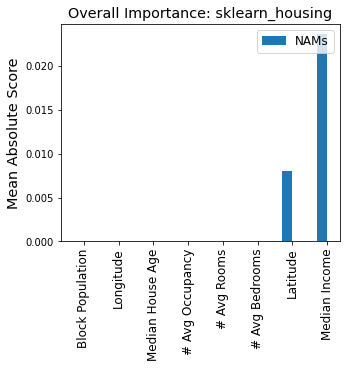

In [199]:
#@title Global feature importance

x1, x2 = compute_mean_feature_importance(avg_hist_data)
cols = [COL_NAMES[dataset_name][x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)


In [200]:
#@title Plotting Helper Functions

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches


def shade_by_density_blocks(hist_data, num_rows, num_cols, n_blocks=5, color=[0.9, 0.5, 0.5], feature_to_use=None):
    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
    max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
    min_max_dif = max_y - min_y
    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif

    if feature_to_use:
        hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

    for i, (name, pred) in enumerate(hist_data_pairs):

        # unique_x_data, single_feature_data, pred = data
        unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
        single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
        ax = plt.subplot(num_rows, num_cols, i + 1)
        min_x = np.min(unique_x_data)
        max_x = np.max(unique_x_data)
        x_n_blocks = min(n_blocks, len(unique_x_data))
        if name in CATEGORICAL_NAMES:
            min_x -= 0.5
            max_x += 0.5
        segments = (max_x - min_x) / x_n_blocks
        density = np.histogram(single_feature_data, bins=x_n_blocks)
        normed_density = density[0] / np.max(density[0])
        rect_params = []
        for p in range(x_n_blocks):
            start_x = min_x + segments * p
            end_x = min_x + segments * (p + 1)
            # start_insert_index = min(
            #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
            # end_insert_index = min(
            #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
            # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
            d = min(1.0, 0.01 + normed_density[p])
            rect_params.append((d, start_x, end_x))

        for param in rect_params:
            alpha, start_x, end_x = param
            rect = patches.Rectangle((start_x, min_y - 1),
                                     end_x - start_x,
                                     max_y - min_y + 1,
                                     linewidth=0.01,
                                     edgecolor=color,
                                     facecolor=color,
                                     alpha=alpha)
            ax.add_patch(rect)


def plot_all_hist(hist_data,
                  num_rows,
                  num_cols,
                  color_base,
                  linewidth=3.0,
                  min_y=None,
                  max_y=None,
                  alpha=1.0,
                  feature_to_use=None):
    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    if min_y is None:
        min_y = np.min([np.min(a) for _, a in hist_data_pairs])
    if max_y is None:
        max_y = np.max([np.max(a) for _, a in hist_data_pairs])
    min_max_dif = max_y - min_y
    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif
    col_mapping = COL_NAMES[dataset_name]
    feature_mapping = FEATURE_LABEL_MAPPING[dataset_name]

    total_mean_bias = 0

    if feature_to_use:
        hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

    for i, (name, pred) in enumerate(hist_data_pairs):
        mean_pred = MEAN_PRED[name]  #np.mean(pred)
        total_mean_bias += mean_pred
        unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
        plt.subplot(num_rows, num_cols, i + 1)

        if name in CATEGORICAL_NAMES:
            unique_x_data = np.round(unique_x_data, decimals=1)
            if len(unique_x_data) <= 2:
                step_loc = "mid"
            else:
                step_loc = "post"
            unique_plot_data = np.array(unique_x_data) - 0.5
            unique_plot_data[-1] += 1
            plt.step(unique_plot_data,
                     pred - mean_pred,
                     color=color_base,
                     linewidth=linewidth,
                     where=step_loc,
                     alpha=alpha)

            if name in feature_mapping:
                labels, rot = feature_mapping[name]
            else:
                labels = unique_x_data
                rot = None
            plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
        else:
            plt.plot(unique_x_data, pred - mean_pred, color=color_base, linewidth=linewidth, alpha=alpha)
            plt.xticks(fontsize='x-large')

        plt.ylim(min_y, max_y)
        plt.yticks(fontsize='x-large')
        min_x = np.min(unique_x_data)
        max_x = np.max(unique_x_data)
        if name in CATEGORICAL_NAMES:
            min_x -= 0.5
            max_x += 0.5
        plt.xlim(min_x, max_x)
        if i % num_cols == 0:
            plt.ylabel('House Price Contribution', fontsize='x-large')
        plt.xlabel(col_mapping[name], fontsize='x-large')
    return min_y, max_y


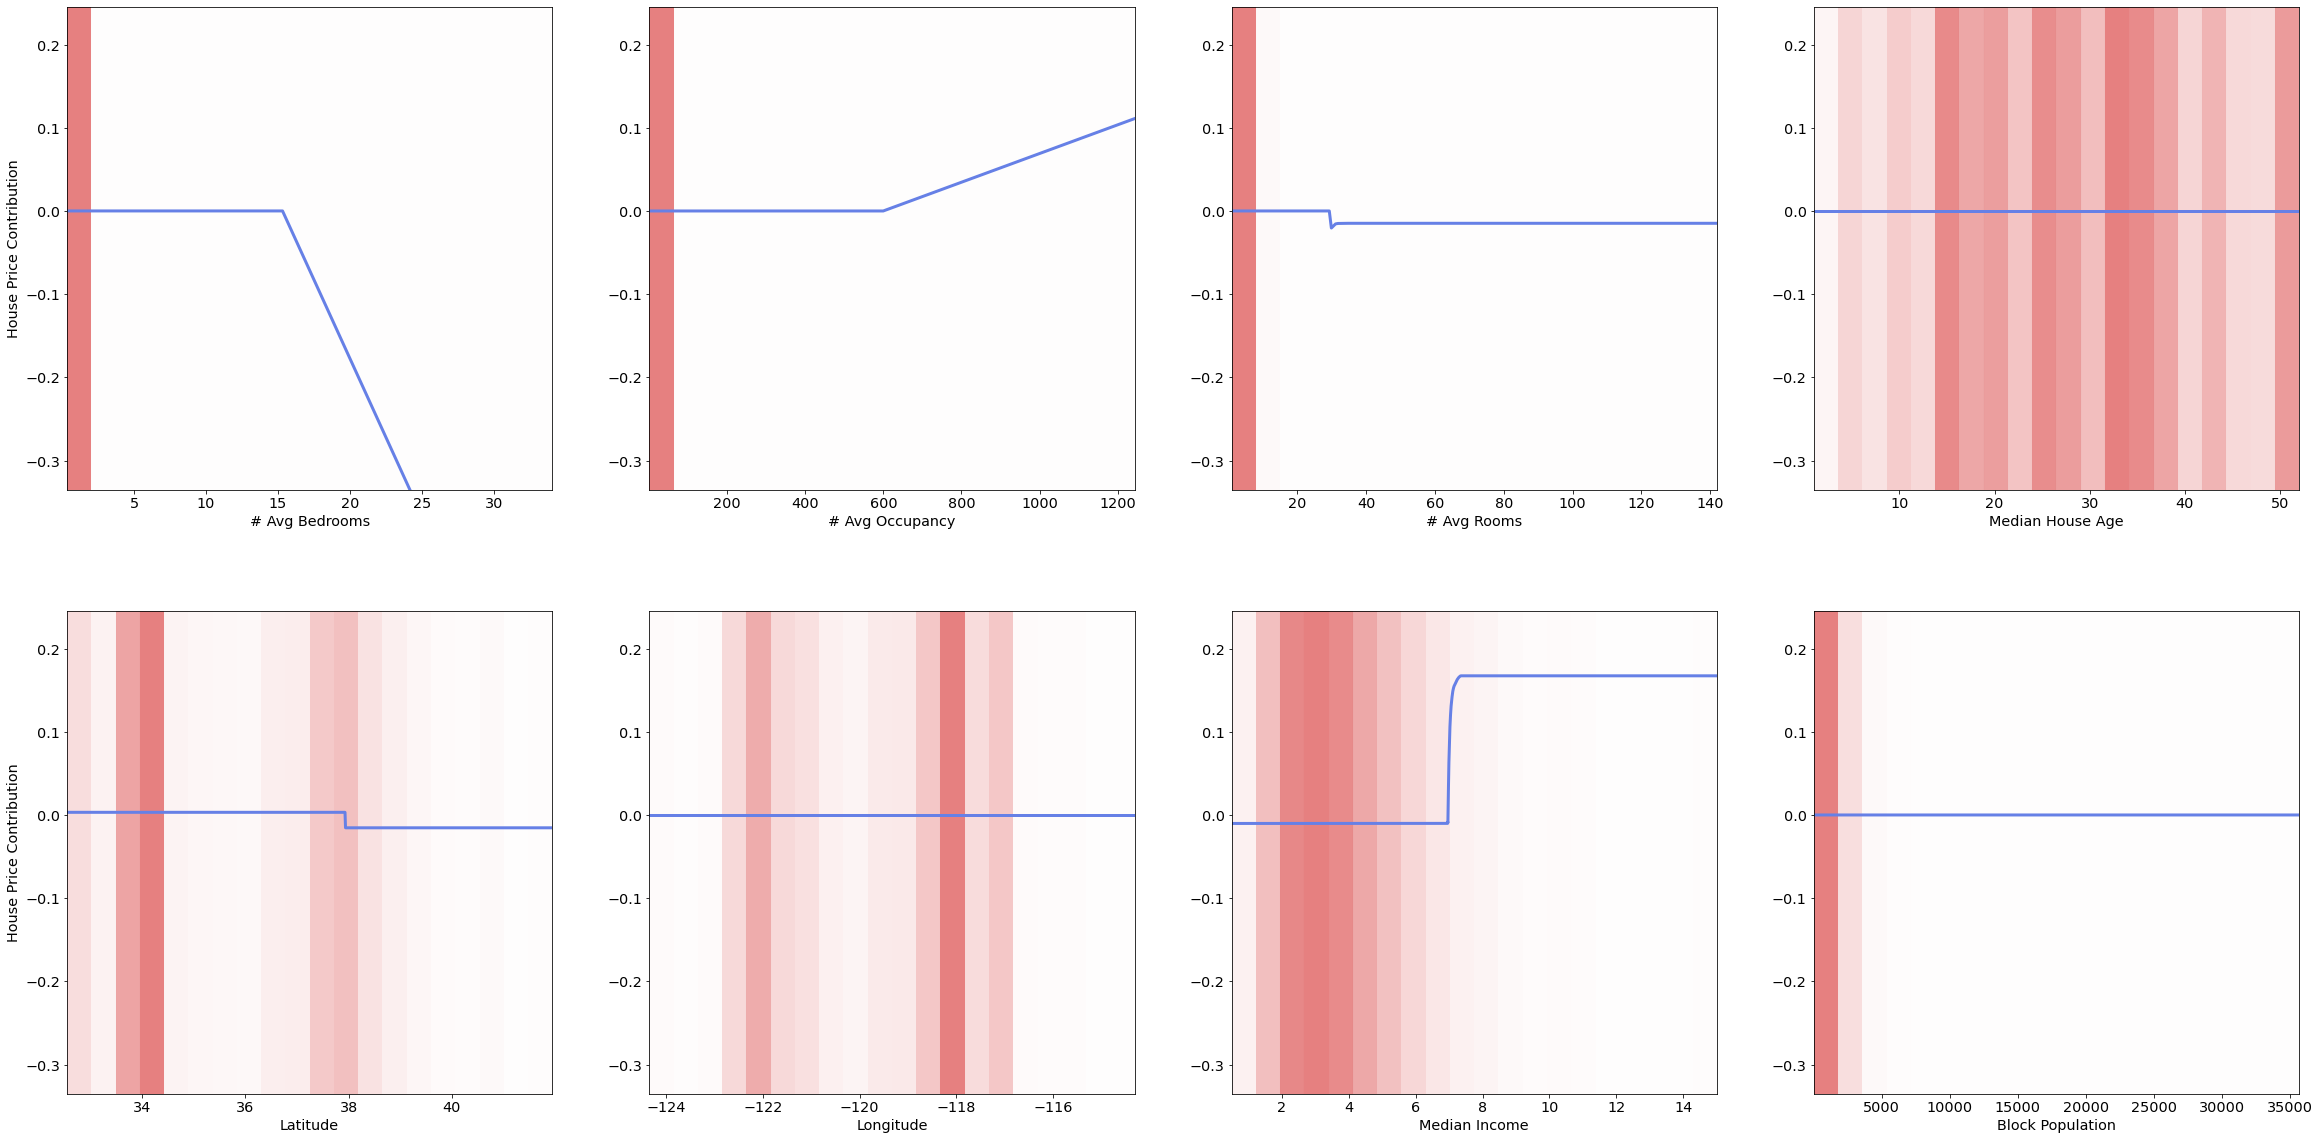

In [201]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS = 4  #@param {'type': 'integer'}
N_BLOCKS = 20  #@param

# MIN_Y = -10#None
# MAX_Y = 10#None
MIN_Y = None
MAX_Y = None

NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 10, NUM_ROWS * 10), facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data,
                             NUM_ROWS,
                             NUM_COLS,
                             COLORS[2],
                             min_y=MIN_Y,
                             max_y=MAX_Y,
                             feature_to_use=column_names)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=column_names)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.25)
plt.show()